In [1]:
# install
# !pip install mlxtend
# !pip install transformers torch
# !pip install transformers tensorflow
# !pip install sentencepiece
# !pip install transformers torch sentencepiece

# 
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read the CSV file into a DataFrame
df = pd.read_csv('../data/Hospital_data_cleaned.csv') 

In [2]:
df.head()

,HOSPITAL,PMT_GRP,SALES_DT,SALES_TM,CHECK_ID,TRANS_ID,CATEGORY,ITEM_NM,GROSS_REV
0,HOSPITAL A,CASH,2024-01-06,11:33:52,25374041,30720877,GRILL & CO,1 TENDER,8.94
1,HOSPITAL A,CASH,2024-06-06,19:08:06,25872838,29838066,GRILL & CO,1 TENDER,2.98
2,HOSPITAL A,CASH,2024-06-10,10:53:45,26109477,29853607,GRILL & CO,1 TENDER,1.49
3,HOSPITAL A,CASH,2024-02-22,18:49:46,26223100,29703893,GRILL & CO,1 TENDER,1.49
4,HOSPITAL A,CASH,2024-02-26,11:51:55,26267834,29705571,GRILL & CO,1 TENDER,1.49


In [26]:
df.dtypes

HOSPITAL      object
PMT_GRP       object
SALES_DT      object
SALES_TM      object
CHECK_ID       int64
TRANS_ID       int64
CATEGORY      object
ITEM_NM       object
GROSS_REV    float64
MONTH          int32
HR_MIN        object
dtype: object

In [24]:
# !pip install transformers tensorflow
# !pip install sentencepiece
# !pip install transformers torch sentencepiece

# Optimization

We assume Beverages make 35% more than Food

# Purchasing Habits
    - PURCHASING HABITS (TIME OF DAY, PRODUCT MIX, SEASONAILITY)
        - REVIEW FOR HOLIDAYS/HIGHEST HOSPITALIZATION TIMES
        - DAY SEASONALITY/MONTH SEASONALITY
        - COMPLIMENTARY GOODS/SUBSTITUTE
    


### Seasonality

We see high levels of seasonality at various levels of detail (monthly; weekly; minute)

We also find either seasonality or trend by category type, many categories may appear to have trend in the short run but turn seasonal as more data populates

<Axes: xlabel='HR'>

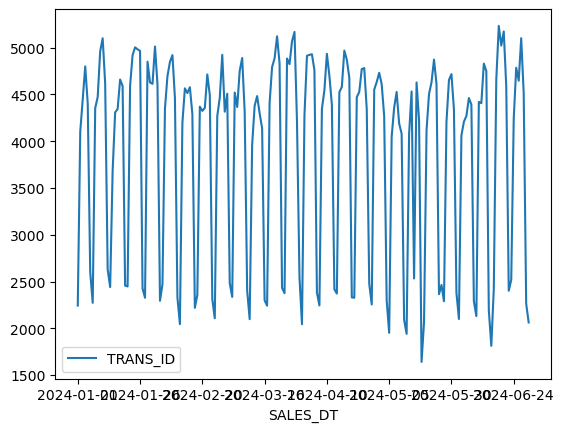

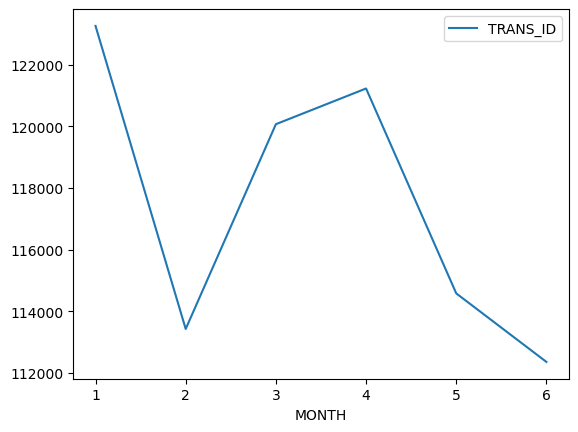

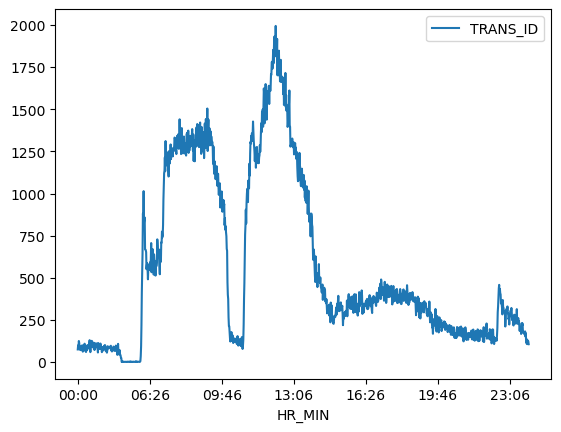

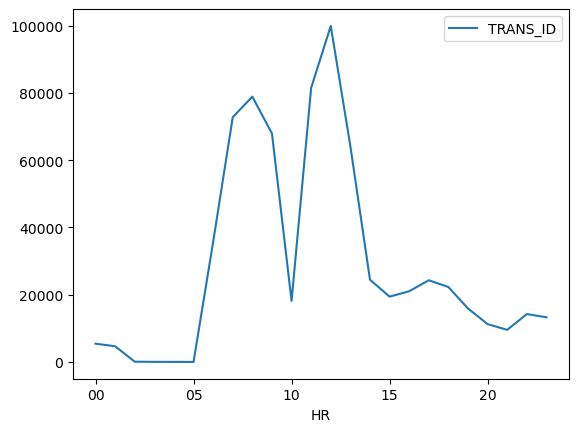

In [30]:
# we see high level of weekly seasonality
# we see monthly seasonality
# we see minute seasonality
# hourly seasonality is less impactful
# some categories experience trend, unable to validate if seasonality vs trend due to time horizon
df['MONTH'] = pd.to_datetime(df['SALES_DT']).dt.month 
df['HR_MIN'] = pd.to_datetime(df['SALES_TM'], format='%H:%M:%S').dt.strftime('%H:%M')
df['HR'] = pd.to_datetime(df['SALES_TM'], format='%H:%M:%S').dt.strftime('%H')
df[['SALES_DT','TRANS_ID']].groupby('SALES_DT').count().plot()
df[['MONTH','TRANS_ID']].groupby('MONTH').count().plot()
df[['HR_MIN','TRANS_ID']].groupby('HR_MIN').count().plot()
df[['HR','TRANS_ID']].groupby('HR').count().plot()

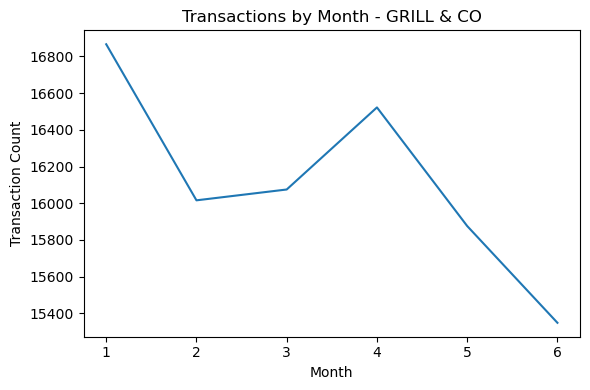

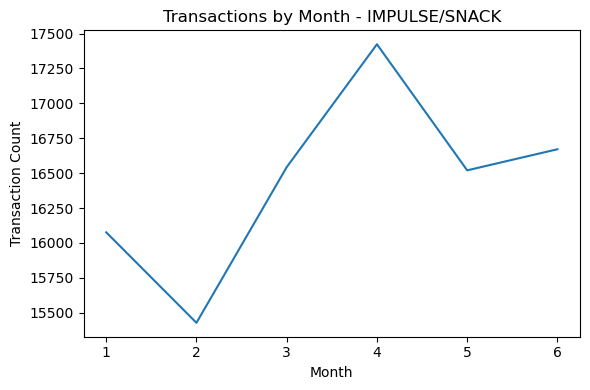

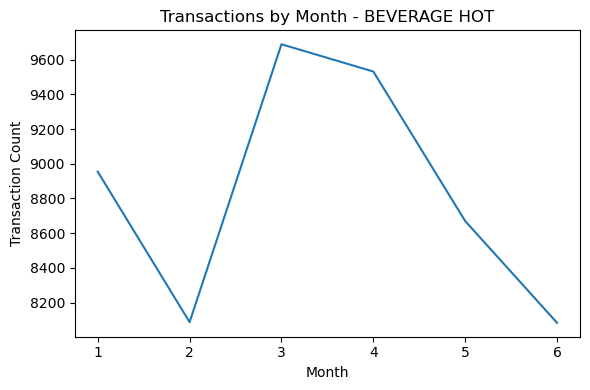

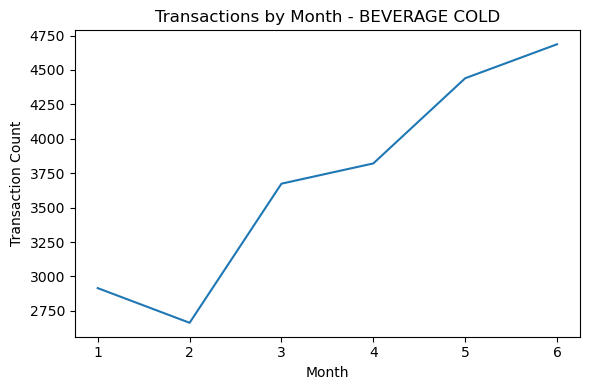

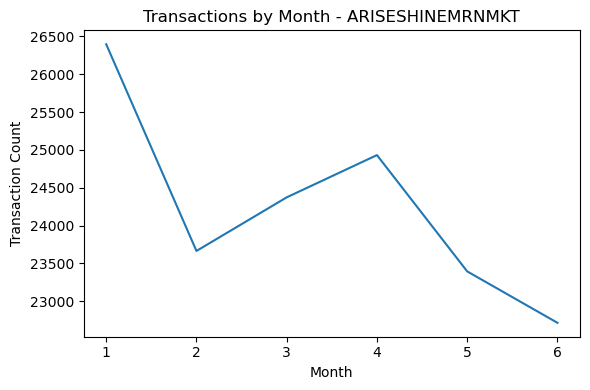

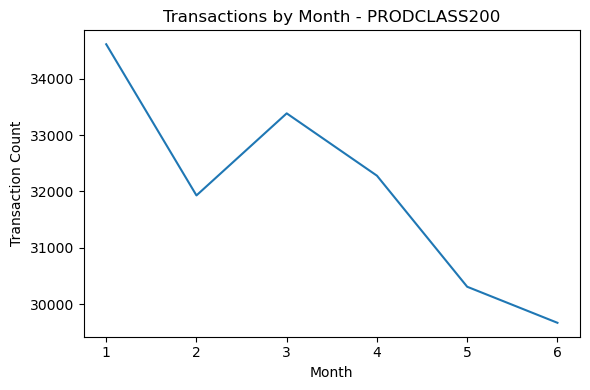

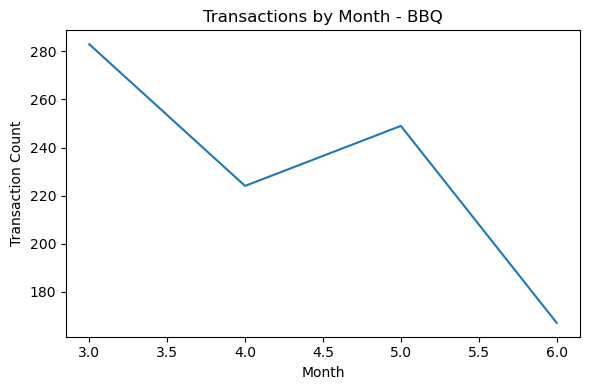

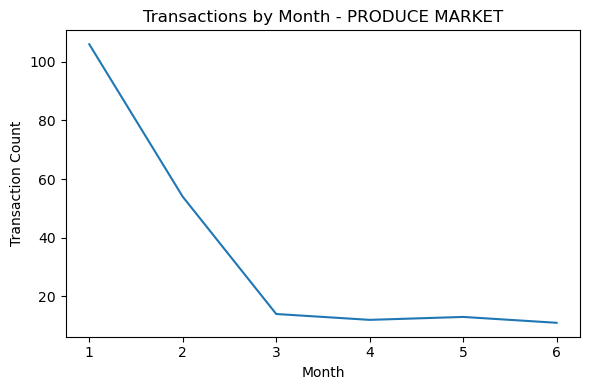

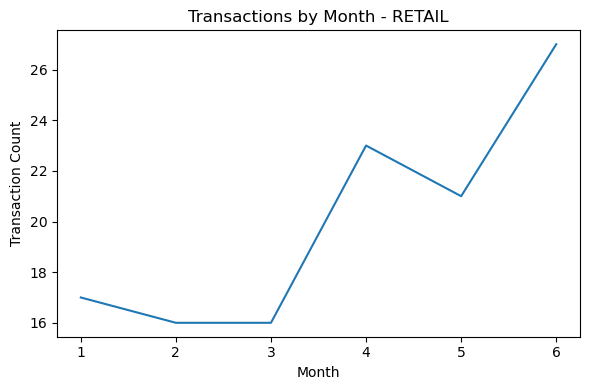

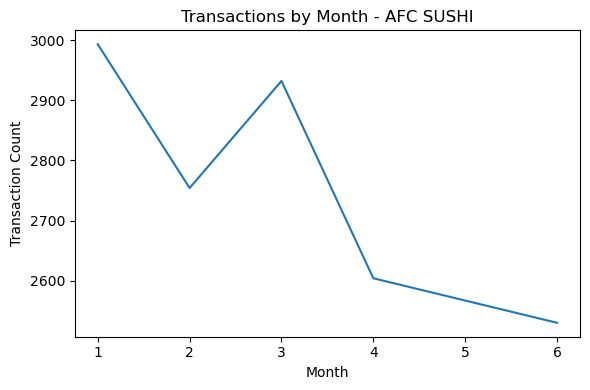

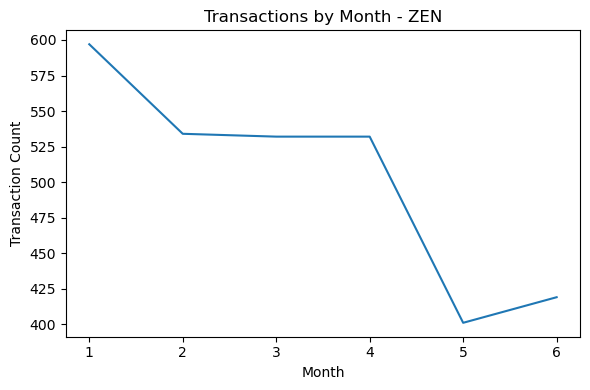

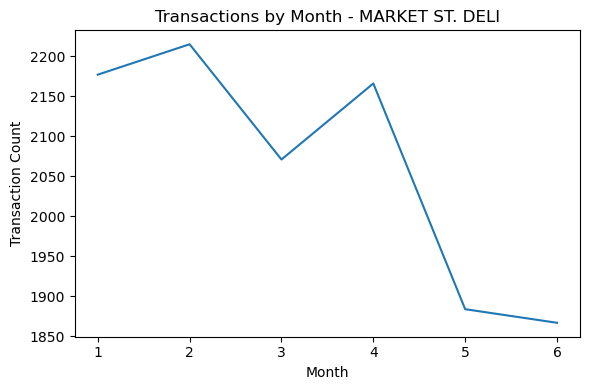

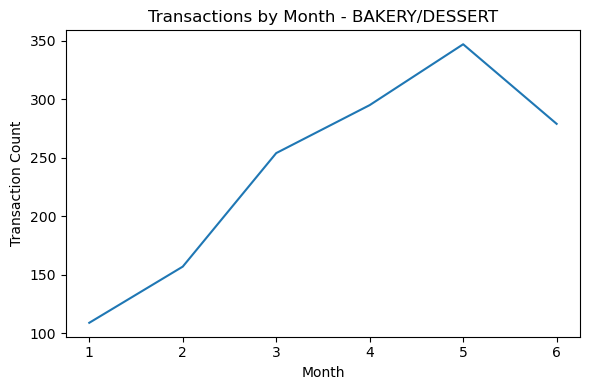

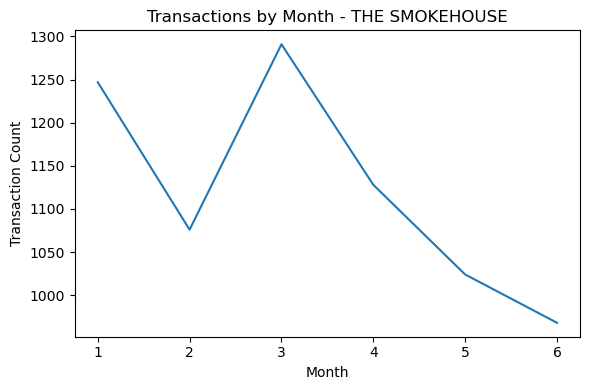

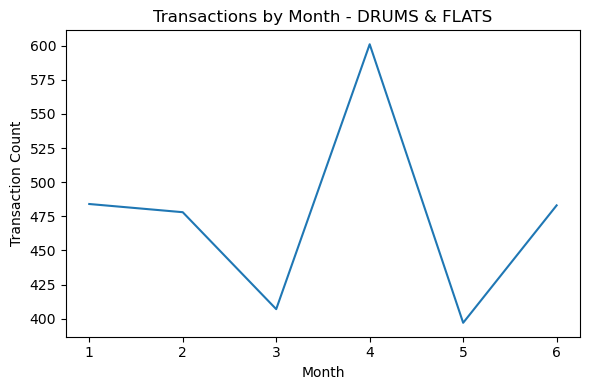

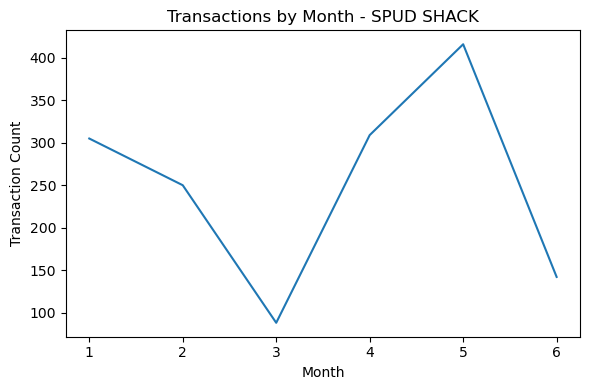

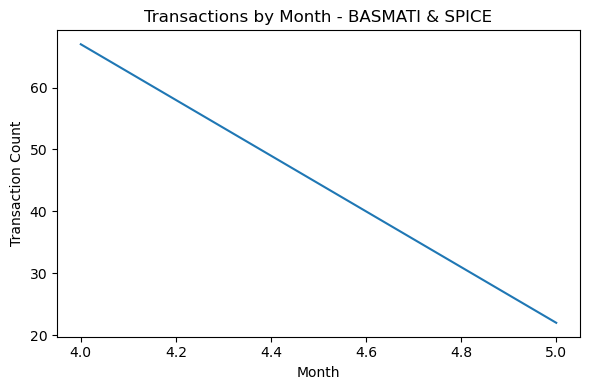

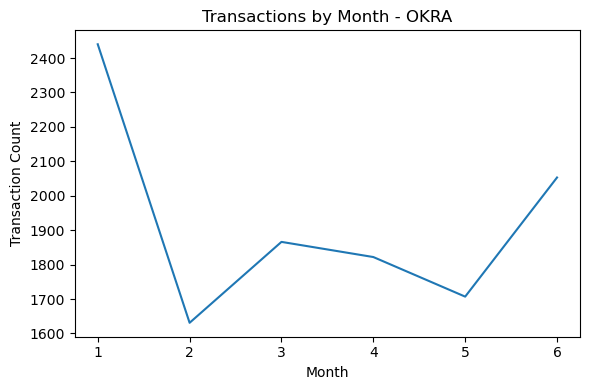

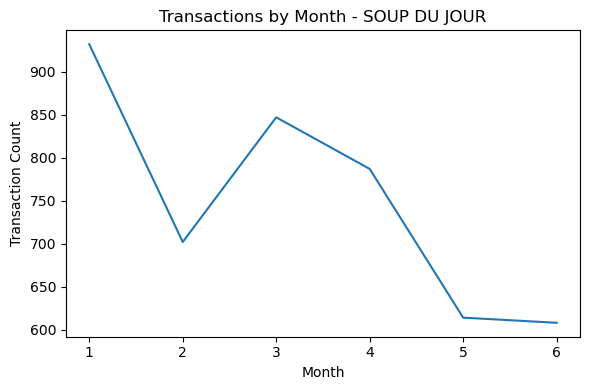

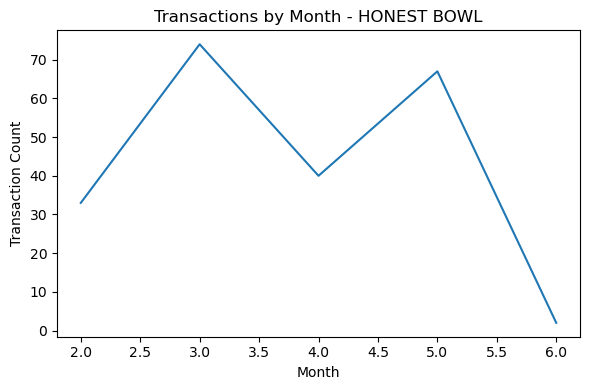

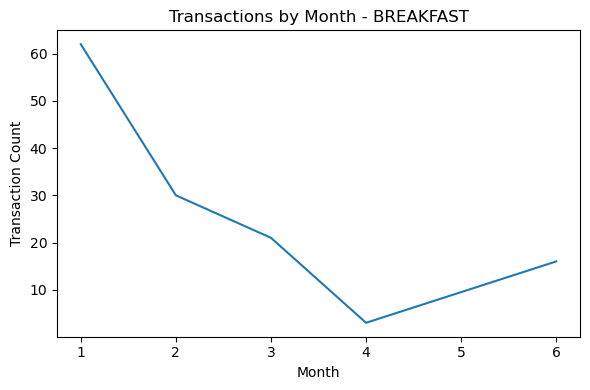

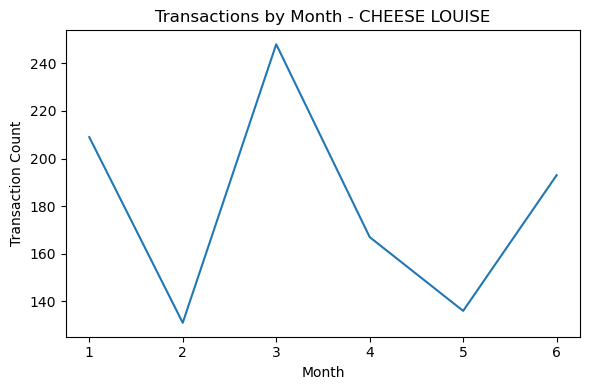

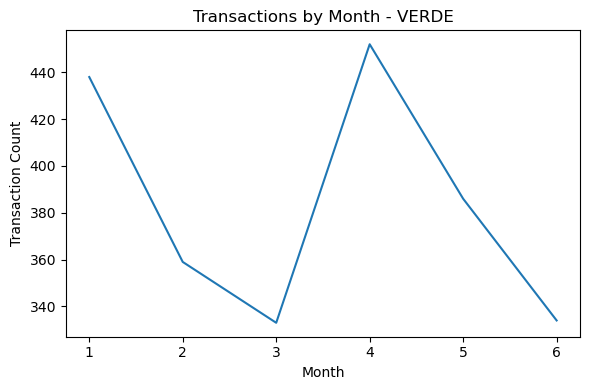

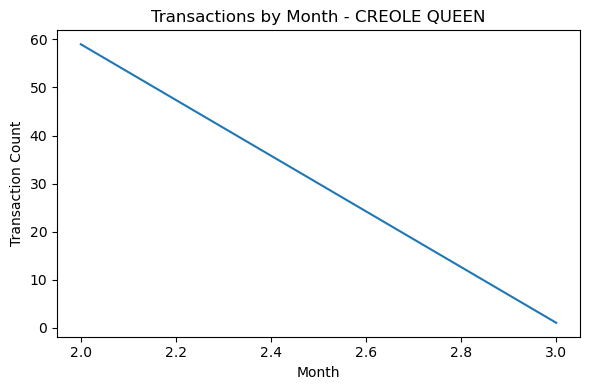

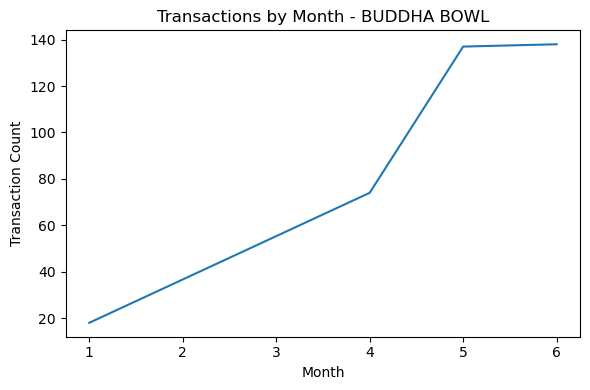

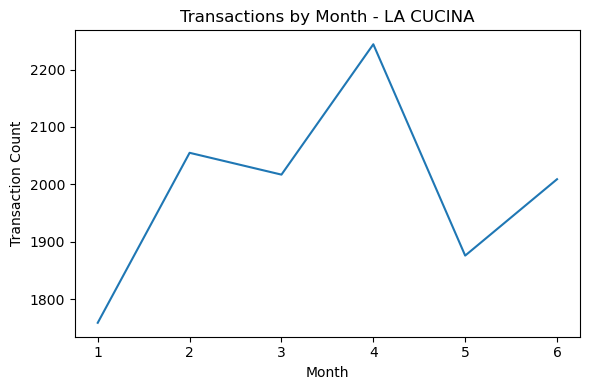

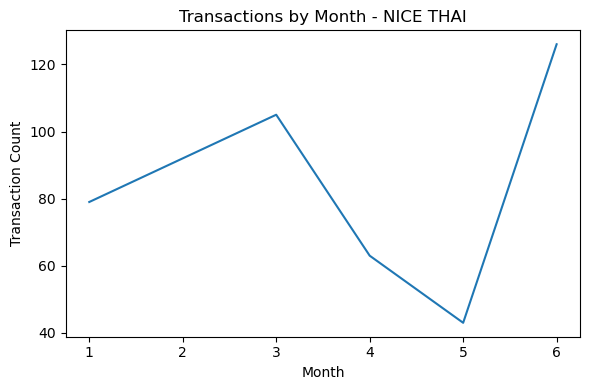

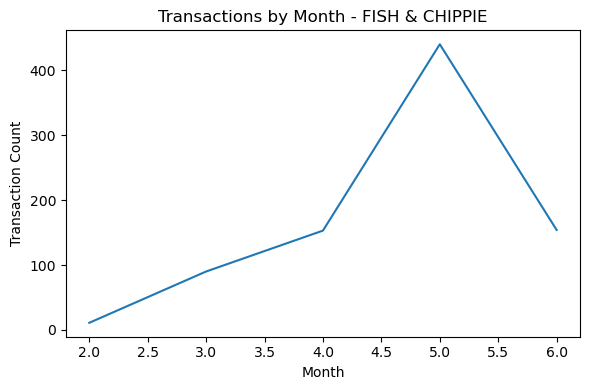

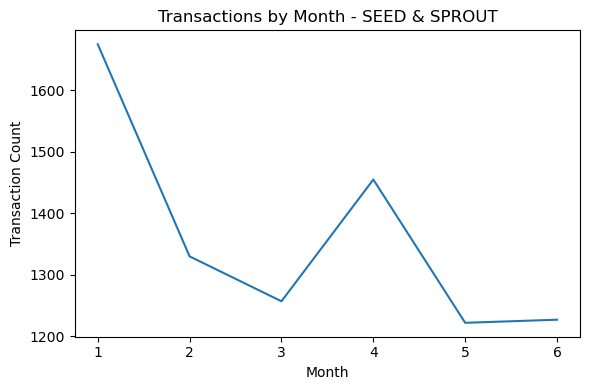

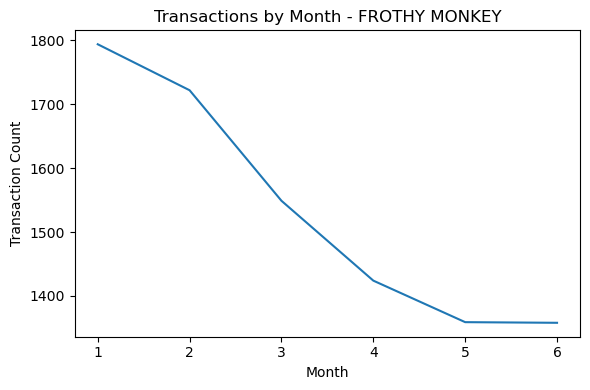

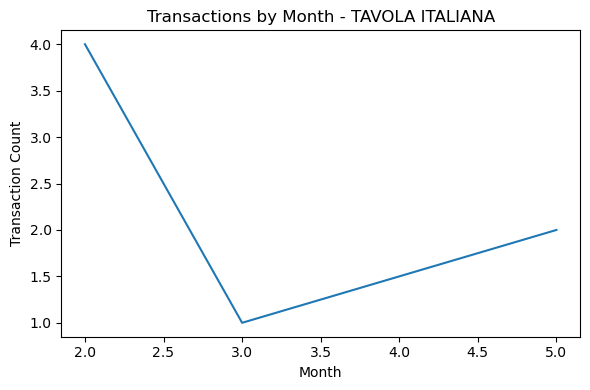

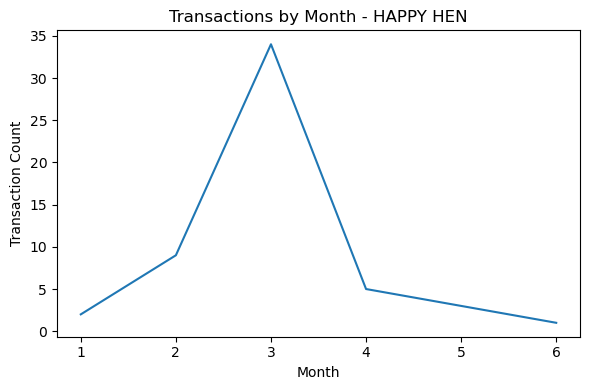

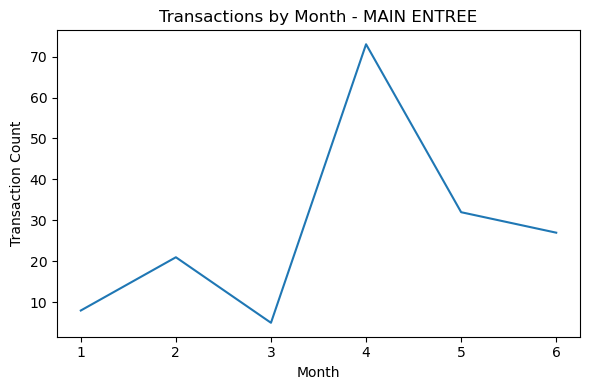

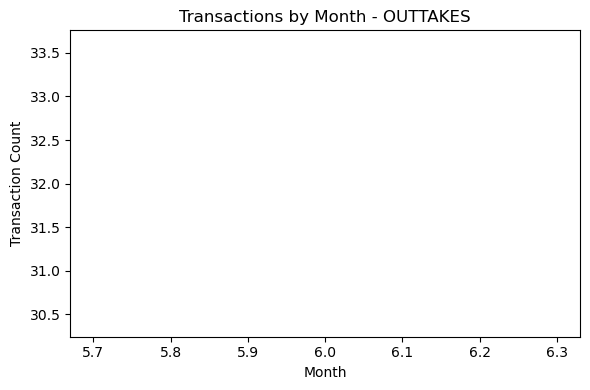

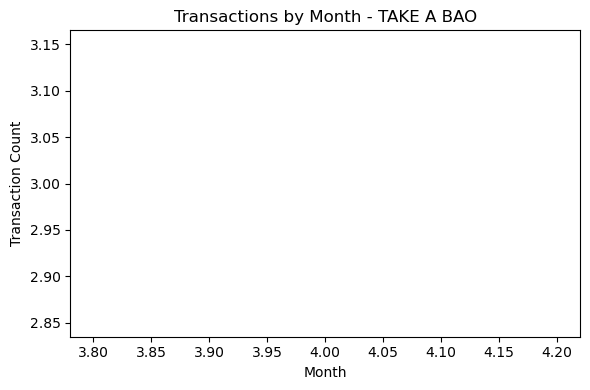

In [50]:
# Extract month
df['MONTH'] = pd.to_datetime(df['SALES_DT']).dt.month

# Loop through each category
for category in df['CATEGORY'].unique():
    subset = df[df['CATEGORY'] == category]

    # Group by month and count transactions
    monthly_counts = subset.groupby('MONTH')['TRANS_ID'].count()

    # Plot
    plt.figure(figsize=(6, 4))
    monthly_counts.plot(kind='line')
    plt.title(f'Transactions by Month - {category}')
    plt.xlabel('Month')
    plt.ylabel('Transaction Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


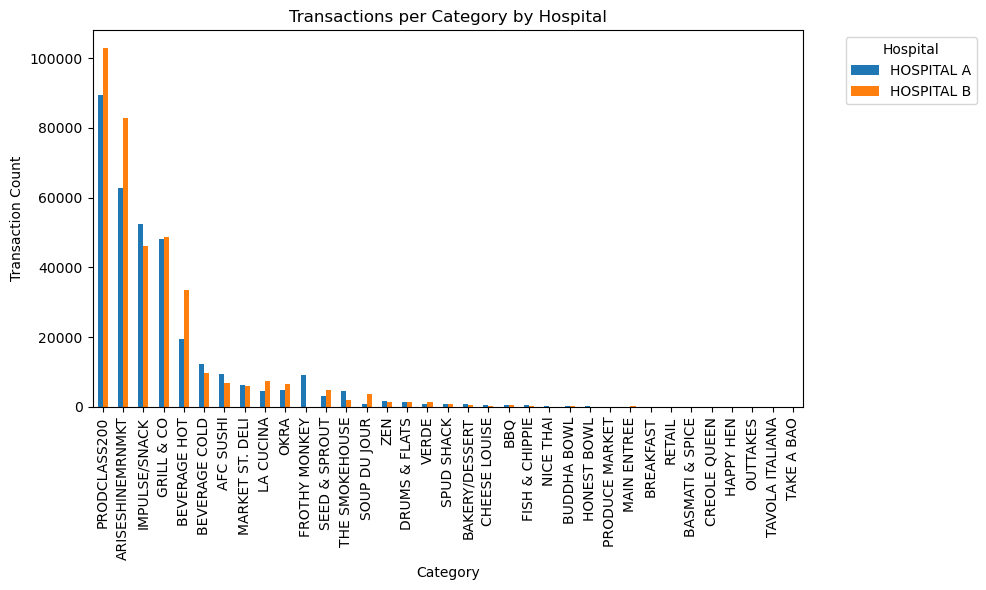

array([[<Axes: title={'center': 'TRANS_ID'}>]], dtype=object)

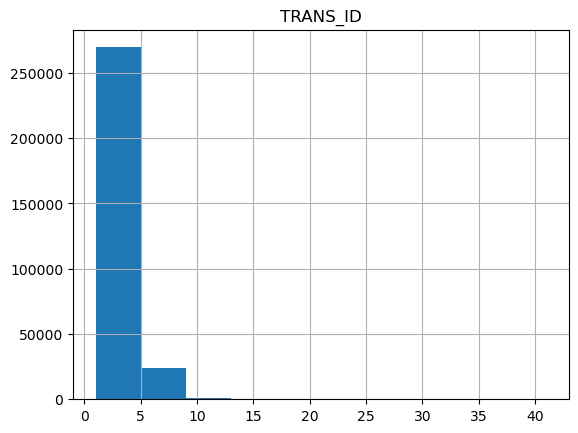

In [98]:
# we have a long tail by category
# most categories have < 25k transactions
# most checks have < 5 items on it


# Group by CATEGORY and HOSPITAL and count transactions
grouped = df.groupby(['CATEGORY', 'HOSPITAL'])['TRANS_ID'].count().unstack().fillna(0)

# Sort categories by total transaction count
grouped = grouped.loc[grouped.sum(axis=1).sort_values(ascending=False).index]

# Plot grouped bar chart
grouped.plot(kind='bar', figsize=(10, 6))

plt.title('Transactions per Category by Hospital')
plt.xlabel('Category')
plt.ylabel('Transaction Count')
plt.legend(title='Hospital', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
# df[['CATEGORY','TRANS_ID']].groupby('CATEGORY').count().sort_values(by = 'TRANS_ID', ascending = False).plot(kind = 'bar')
df[['CHECK_ID','TRANS_ID']].groupby('CHECK_ID').count().hist()

In [118]:
# find number of items by check id along with total revnue
agg1 = df.groupby('CHECK_ID').agg(
    TRANS_COUNT=('TRANS_ID', 'count'),
    TOTAL_REV=('GROSS_REV', 'sum')
).reset_index()

# by trans count find average rev

agg1[['TRANS_COUNT','TOTAL_REV']].groupby('TRANS_COUNT').agg(
    TOTAL_REV = ('TOTAL_REV','sum')
    ,AVG_REV = ('TOTAL_REV','mean')
    ,N_TRANS = ('TRANS_COUNT','sum')
).reset_index().head()

,TRANS_COUNT,TOTAL_REV,AVG_REV,N_TRANS
0,1,398725.62,4.432501,89955
1,2,739870.51,7.994711,185090
2,3,614432.57,10.580166,174222
3,4,365066.05,12.559900,116264
4,5,207163.12,14.725840,70340


In [56]:
# df[['CATEGORY','TRANS_ID']].groupby('CATEGORY').count().reset_index().sort_values(by = 'TRANS_ID')

df[['CATEGORY','TRANS_ID']].groupby('CATEGORY').count().reset_index().sort_values(by = 'TRANS_ID')

In [64]:
# Create a binary basket format: 1 if item is in the check
basket = df.groupby(['CHECK_ID', 'ITEM_NM'])['ITEM_NM'].count().unstack().fillna(0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

/var/folders/tz/9fjc264571x3xp1x0w6_cwgw0000gn/T/ipykernel_4100/1557416230.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


In [69]:
from mlxtend.frequent_patterns import apriori, association_rules

# Find frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# Generate rules (optional)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Top item combinations
print(frequent_itemsets.sort_values(by='support', ascending=False).head(10))

/opt/anaconda3/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


     support                 itemsets
22  0.086186         (SCRAMBLED EGGS)
4   0.083362                  (BACON)
5   0.077096                (BISCUIT)
7   0.072623        (CHICKEN TENDERS)
14  0.070238          (LARGE FRY CUP)
25  0.056658         (SMASHED BURGER)
0   0.052548            (12OZ COFFEE)
13  0.049708            (HASH BROWNS)
38  0.048742  (BACON, SCRAMBLED EGGS)
24  0.047048          (SMALL FRY CUP)
